In [1]:
# Kreiss-Ystrom equations: without higher order terms
# Kreiss-Ystrom equations: with higher order terms
# Kreiss-Ystrom equations: with higher order terms, with preconditioners and solvers parameters
# Kreiss-Ystrom equations: with higher order terms, with preconditioners and solvers parameters + functions

# KY EIGENVALUE PROBLEM without higher order terms 
# KY EIGENVALUE PROBLEM with higher order terms


In [2]:
# Kreiss-Ystrom equations: without higher order terms

# https://fenicsproject.org/pub/tutorial/html/._ftut1017.html
"""
WAVE PDE SYSTEM
Solution of convection-diffusion equation using CG and backward Crank Nicholson
PDE: 
IC : 
BC : DIRICHLET

https://fenicsproject.discourse.group/t/aritymismatch-for-crank-nicolson-method-on-mixed-function-space/781/3
"""

from __future__ import print_function
from IPython.display import clear_output
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time


# Form compiler options
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
#parameters["form_compiler"]["representation"] = "quadrature"
parameters ["form_compiler"]["quadrature_degree"] = 2

parameters ["form_compiler"]["cpp_optimize"]      = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Define constants
u1bc1   = 0.5 # alpha0
u2bc1   = 1.0 # u0
C       = - 1 # 1 non hyperbolic
nu      = 0.01 # 0 without viscosity (ill posed)
epsilon = 0.01

# Define space discretization properties
xmin   = 0
xmax   = 2*pi
nx     = 200 # no. of elements 100 to 800
p      = 1  # degree of FEM
mesh   = IntervalMesh (nx, xmin, xmax)
#h      = CellDiameter (mesh)
#hmin   = mesh.hmin ()
deltax = 0.02 # 1 to 0.02m

# Save mesh
File ("kreiss_ystrom/mesh.xml") << mesh

# Define time discretization properties
T         = 5.0            # final time
Co        = 0.5
dt        = Co*deltax/u2bc1 # 0.004*deltax
num_steps = round(T / dt)

# Define funcion spaces
V1      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
V2      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
element = MixedElement ([V1, V2])
V       = FunctionSpace (mesh, element)

# Define test and trial functions
v1, v2     = TestFunctions (V)

u          = Function (V, name = "Variables at current step")
u1, u2     = split (u)

du         = TrialFunction (V)

# Define initial condition
class InitialConditions (UserExpression):
    def __init__ (self, **kwargs):
        super (InitialConditions, self).__init__(**kwargs)
    def eval (self, values, x):
        values[0] = u1bc1
        values[1] = u2bc1
    def value_shape (self):
        return (2,)

u_ic       = InitialConditions(degree = p)
u_n        = interpolate (u_ic, V) 
u_n1, u_n2 = split (u_n)

# Define boundary condition
u1_bc1 = Expression ("u1bc1", degree = p, u1bc1 = u1bc1)
#u1_bc2 = Expression ("u1bc2", degree = p, u1bc2 = u1bc2)
u2_bc1 = Expression ("u2bc1", degree = p, u2bc1 = u2bc1)
#u2_bc2 = Expression ("u2bc2", degree = p, u2bc2 = u2bc2)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1 = DirichletBC(V.sub (0), u1_bc1, left)
#bc2 = DirichletBC(V.sub (1), u1_bc2, right)
bc3 = DirichletBC(V.sub (1), u2_bc1, left)
#bc4 = DirichletBC(V.sub (1), u2_bc2, right)
bcs = [bc1, bc3]

# Define expressions used in weak form
k       = Expression ("dt", degree = p, dt = dt)
nu      = Expression ("nu", degree = p, nu = nu)
epsilon = Expression ("epsilon", degree = p, epsilon = epsilon)
C       = Expression ("C", degree = p, C = C)

# Define weak form
F = ((u1 - u_n1) / k)*v1*dx + (u2*v1*Dx(u1,0))*dx + (1+u1/2)*(v1*Dx(u2,0))*dx + 2*u1*v1*dx +\
((u2 - u_n2) / k)*v2*dx + (u2*v2*Dx(u2,0))*dx - (C*v2*Dx(u1,0))*dx

# (inner(epsilon*grad(u1), grad(v1)))*dx
# (mu*inner(grad(u2), grad(v)))*dx

#F = u1*v1*dx - 0.5*k*u2*v1*dx - (u_n1*v1*dx + 0.5*k*u_n2*v1*dx) +\
#u2*v2*dx + 0.5*c**2*k*inner(grad(u1), grad(v2))*dx - (u_n2*v2*dx - 0.5*c**2*k*inner(grad(u_n1), grad(v2))*dx)

# Define Jacobian
dF = derivative (F, u, du)

# Define files
ff1 = File ("kreiss_ystrom/u1.pvd", "compressed")
ff2 = File ("kreiss_ystrom/u2.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time
    t += dt
    #u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F, u, bcs = bcs, J = dF)
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters

    # Define solver parameters
    #info(prm, True)
    
    prm = solver.parameters
    prm ['newton_solver']['report']                  = True
    prm ['newton_solver']['absolute_tolerance']      = 1E-8
    prm ['newton_solver']['relative_tolerance']      = 1E-7
    prm ['newton_solver']['maximum_iterations']      = 100
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['convergence_criterion']   = 'incremental' #'residual'
    prm ['newton_solver']['error_on_nonconvergence'] = True
    
    prm ['newton_solver']['linear_solver']                       = 'gmres'
    prm ['newton_solver']['preconditioner']                      = 'ilu'
    prm ['newton_solver']['lu_solver']['report']                 = True
    prm ['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-6
    prm ['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-10
    prm ['newton_solver']['krylov_solver']['maximum_iterations'] = 10000
    
    #prm['newton_solver']['krylov_solver']['gmres']['restart'] = 40
    #prm['newton_solver']['krylov_solver']['preconditioner']['ilu']['fill_level'] = 0
    #prm['newton_solver']['lu_solver']['same_nonzero_pattern'] = True   
    
    #prm['nonlinear_solver']='snes'
    #prm['snes_solver']['absolute_tolerance']=1e-6
    #prm['snes_solver']['maximum_iterations']=2000
    
    solver.solve ()
    
    (u1,u2) = u.split (deepcopy = True)
    
    # Plot solution
    plt.figure (1, figsize = (8, 4))
    #plt.clf()
    plot (u1) #plot alpha from 0.5 to 0.9
    
    plt.figure (2, figsize = (8, 4))
    #plt.clf()
    plot (u2)
    
    # Update previous solution
    u_n.assign (u)
    
    # Save solution
    ff1 << u1
    ff2 << u2

# Hold plot
plt.show ()

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))



Iteration : 499.99999999999375 of 500
Time      : 4.999999999999938 s


Time of the program's execution: 5.8650970458984375e-05 seconds 


Iteration : 1570.9999999999377 of 1571
Time      : 6.283999999999751 s


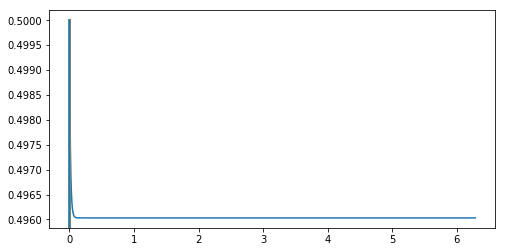

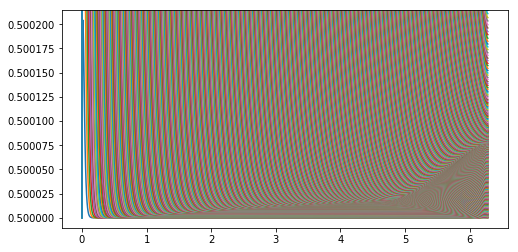

Time of the program's execution: 3.814697265625e-05 seconds 


In [4]:
# Kreiss-Ystrom equations: with higher order terms
# Parameters
# https://fenicsproject.org/pub/tutorial/html/._ftut1017.html

# Kreiss Ystrom CHAOS article

"""
WAVE PDE SYSTEM
Solution of convection-diffusion equation using CG and backward Crank Nicholson
PDE: 
IC : 
BC : DIRICHLET

https://fenicsproject.discourse.group/t/aritymismatch-for-crank-nicolson-method-on-mixed-function-space/781/3
"""

from __future__ import print_function
from IPython.display import clear_output
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time


# Form compiler options
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
#parameters["form_compiler"]["representation"] = "quadrature"
parameters ["form_compiler"]["quadrature_degree"] = 2

parameters ["form_compiler"]["cpp_optimize"]      = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Define constants
u1bc1   = 0.5 # alpha0
u2bc1   = 0.5 # u0 = 1.0
C       = - 1 # 1 non hyperbolic
nu      = 0.05 # 0 without viscosity (ill posed)
epsilon = 0.05

# Define space discretization properties
xmin   = 0
xmax   = 2*pi
nx     = 800 # no. of elements 100 to 800
p      = 2  # degree of FEM
mesh   = IntervalMesh (nx, xmin, xmax)
#h      = CellDiameter (mesh)
#hmin   = mesh.hmin ()
#deltax = 0.02 # 1 to 0.02m

# Save mesh
File ("kreiss-ystrom_higherorder/mesh.xml") << mesh

# Define time discretization properties
T         = 2*pi            # final time
Co        = 0.5
dt        = 0.004 #Co*deltax/u2bc1 # 0.004*deltax
num_steps = round(T / dt)

# Define funcion spaces
V1      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
V2      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
element = MixedElement ([V1, V2])
V       = FunctionSpace (mesh, element)

# Define test and trial functions
v1, v2     = TestFunctions (V)

u          = Function (V, name = "Variables at current step")
u1, u2     = split (u)

du         = TrialFunction (V)

# Define initial condition
class InitialConditions (UserExpression):
    def __init__ (self, **kwargs):
        super (InitialConditions, self).__init__(**kwargs)
    def eval (self, values, x):
        values[0] = u1bc1
        values[1] = u2bc1
    def value_shape (self):
        return (2,)

u_ic       = InitialConditions(degree = p)
u_n        = interpolate (u_ic, V) 
u_n1, u_n2 = split (u_n)

# Define boundary condition
u1_bc1 = Expression ("u1bc1", degree = p, u1bc1 = u1bc1)
#u1_bc2 = Expression ("u1bc2", degree = p, u1bc2 = u1bc2)
u2_bc1 = Expression ("u2bc1", degree = p, u2bc1 = u2bc1)
#u2_bc2 = Expression ("u2bc2", degree = p, u2bc2 = u2bc2)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1 = DirichletBC(V.sub (0), u1_bc1, left)
#bc2 = DirichletBC(V.sub (1), u1_bc2, right)
bc3 = DirichletBC(V.sub (1), u2_bc1, left)
#bc4 = DirichletBC(V.sub (1), u2_bc2, right)
bcs = [bc1, bc3]

# Define expressions used in weak form
k       = Expression ("dt", degree = p, dt = dt)
nu      = Expression ("nu", degree = p, nu = nu)
epsilon = Expression ("epsilon", degree = p, epsilon = epsilon)
C       = Expression ("C", degree = p, C = C)

# Define weak form
F = ((u1 - u_n1) / k)*v1*dx + (u2*v1*Dx(u1,0))*dx + (1+u1/2)*(v1*Dx(u2,0))*dx + 2*u1*v1*dx + (inner(epsilon*grad(u1), grad(v1)))*dx +\
((u2 - u_n2) / k)*v2*dx + (u2*v2*Dx(u2,0))*dx - (C*v2*Dx(u1,0))*dx + (inner(nu*grad(u2), grad(v2)))*dx

#F = u1*v1*dx - 0.5*k*u2*v1*dx - (u_n1*v1*dx + 0.5*k*u_n2*v1*dx) +\
#u2*v2*dx + 0.5*c**2*k*inner(grad(u1), grad(v2))*dx - (u_n2*v2*dx - 0.5*c**2*k*inner(grad(u_n1), grad(v2))*dx)

# Define Jacobian
dF = derivative (F, u, du)

# Define files
ff1 = File ("kreiss-ystrom_higherorder/u1.pvd", "compressed")
ff2 = File ("kreiss-ystrom_higherorder/u2.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time
    t += dt
    #u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F, u, bcs = bcs, J = dF)
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters

    # Define solver parameters
    #info(prm, True)
    
    # https://fenicsproject.org/qa/5800/linear-solver-choice/  ******* Check the 
    prm = solver.parameters
    prm ['newton_solver']['report']                  = True
    prm ['newton_solver']['absolute_tolerance']      = 1E-8
    prm ['newton_solver']['relative_tolerance']      = 1E-7
    prm ['newton_solver']['maximum_iterations']      = 100
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['convergence_criterion']   = 'incremental' #'residual'
    prm ['newton_solver']['error_on_nonconvergence'] = True
    
    prm ['newton_solver']['linear_solver']                       = 'bicgstab'# 'gmres' (umfpack cannot have preconditioner ilu)
    #prm ['newton_solver']['preconditioner']                      = 'ilu'
    prm ['newton_solver']['lu_solver']['report']                 = True
    prm ['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-6
    prm ['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-10
    prm ['newton_solver']['krylov_solver']["monitor_convergence"] = True
    prm ['newton_solver']['krylov_solver']['maximum_iterations'] = 100
    
    #prm['newton_solver']['krylov_solver']['gmres']['restart'] = 40
    #prm['newton_solver']['krylov_solver']['preconditioner']['ilu']['fill_level'] = 0
    #prm['newton_solver']['lu_solver']['same_nonzero_pattern'] = True   
    
    #prm['nonlinear_solver']='snes'
    #prm['snes_solver']['absolute_tolerance']=1e-6
    #prm['snes_solver']['maximum_iterations']=2000
    
    solver.solve ()
    
    (u1,u2) = u.split (deepcopy = True)
    
    # Plot solution
    plt.figure (1, figsize = (8, 4))
    #plt.clf()
    plot (u1) #plot alpha from 0.5 to 0.9
    
    plt.figure (2, figsize = (8, 4))
    #plt.clf()
    plot (u2)
    
    # Update previous solution
    u_n.assign (u)
    
    # Save solution
    ff1 << u1
    ff2 << u2

# Hold plot
plt.show ()

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))
    
    
    ####como subir o grau do polinomio???

Iteration : 499.99999999999375 of 500
Time      : 9.999999999999876 s


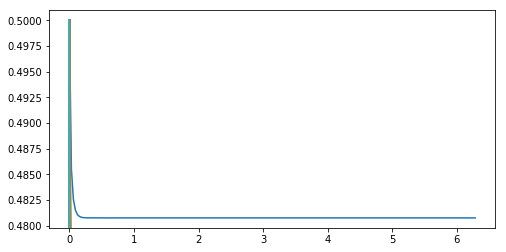

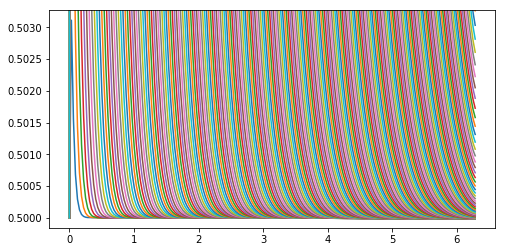

Time of the program's execution: 0.00012969970703125 seconds 


In [4]:
# Kreiss-Ystrom equations: with higher order terms, with preconditioners and solvers parameters
# Parameters
# https://fenicsproject.org/pub/tutorial/html/._ftut1017.html
"""
WAVE PDE SYSTEM
Solution of convection-diffusion equation using CG and backward Crank Nicholson
PDE: 
IC : 
BC : DIRICHLET

https://fenicsproject.discourse.group/t/aritymismatch-for-crank-nicolson-method-on-mixed-function-space/781/3
"""

from __future__ import print_function
from IPython.display import clear_output
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time


# Form compiler options
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
#parameters["form_compiler"]["representation"] = "quadrature"
parameters ["form_compiler"]["quadrature_degree"] = 2

parameters ["form_compiler"]["cpp_optimize"]      = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Define constants
u1bc1   = 0.5 # alpha0
u2bc1   = 0.5 # u0 = 1.0
C       = - 1 # 1 non hyperbolic
nu      = 0.01 # 0 without viscosity (ill posed)
epsilon = 0.01

# Define space discretization properties
xmin   = 0
xmax   = 2*pi
nx     = 200 # no. of elements 100 to 800
p      = 2  # degree of FEM
mesh   = IntervalMesh (nx, xmin, xmax)
#h      = CellDiameter (mesh)
#hmin   = mesh.hmin ()
deltax = 0.02 # 1 to 0.02m

# Save mesh
File ("kreiss-ystrom_higherorder_prec_solvers/mesh.xml") << mesh

# Define time discretization properties
T         = 10.0            # final time
Co        = 0.5
dt        = Co*deltax/u2bc1 # 0.004*deltax
num_steps = round(T / dt)

# Define funcion spaces
V1      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
V2      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
element = MixedElement ([V1, V2])
V       = FunctionSpace (mesh, element)

# Define test and trial functions
v1, v2     = TestFunctions (V)

u          = Function (V, name = "Variables at current step")
u1, u2     = split (u)

du         = TrialFunction (V)

# Define initial condition
class InitialConditions (UserExpression):
    def __init__ (self, **kwargs):
        super (InitialConditions, self).__init__(**kwargs)
    def eval (self, values, x):
        values[0] = u1bc1
        values[1] = u2bc1
    def value_shape (self):
        return (2,)

u_ic       = InitialConditions(degree = p)
u_n        = interpolate (u_ic, V) 
u_n1, u_n2 = split (u_n)

# Define boundary condition
u1_bc1 = Expression ("u1bc1", degree = p, u1bc1 = u1bc1)
#u1_bc2 = Expression ("u1bc2", degree = p, u1bc2 = u1bc2)
u2_bc1 = Expression ("u2bc1", degree = p, u2bc1 = u2bc1)
#u2_bc2 = Expression ("u2bc2", degree = p, u2bc2 = u2bc2)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1 = DirichletBC(V.sub (0), u1_bc1, left)
#bc2 = DirichletBC(V.sub (1), u1_bc2, right)
bc3 = DirichletBC(V.sub (1), u2_bc1, left)
#bc4 = DirichletBC(V.sub (1), u2_bc2, right)
bcs = [bc1, bc3]

# Define expressions used in weak form
k       = Expression ("dt", degree = p, dt = dt)
nu      = Expression ("nu", degree = p, nu = nu)
epsilon = Expression ("epsilon", degree = p, epsilon = epsilon)
C       = Expression ("C", degree = p, C = C)

# Define weak form
F = ((u1 - u_n1) / k)*v1*dx + (u2*v1*Dx(u1,0))*dx + (1+u1/2)*(v1*Dx(u2,0))*dx + 2*u1*v1*dx + (inner(epsilon*grad(u1), grad(v1)))*dx +\
((u2 - u_n2) / k)*v2*dx + (u2*v2*Dx(u2,0))*dx - (C*v2*Dx(u1,0))*dx + (inner(nu*grad(u2), grad(v2)))*dx

#F = u1*v1*dx - 0.5*k*u2*v1*dx - (u_n1*v1*dx + 0.5*k*u_n2*v1*dx) +\
#u2*v2*dx + 0.5*c**2*k*inner(grad(u1), grad(v2))*dx - (u_n2*v2*dx - 0.5*c**2*k*inner(grad(u_n1), grad(v2))*dx)

# Define Jacobian
dF = derivative (F, u, du)

# Define files
ff1 = File ("kreiss-ystrom_higherorder_prec_solvers/u1.pvd", "compressed")
ff2 = File ("kreiss-ystrom_higherorder_prec_solvers/u2.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time
    t += dt
    #u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F, u, bcs = bcs, J = dF)
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters
    
    info(prm, True)
    
    prm ['nonlinear_solver'] = 'newton'
    prm ['print_matrix']     = False #True
    prm ['print_rhs']        = False #True
    prm ['symmetric']        = False #True
    
    prm ['newton_solver']['absolute_tolerance']      = 1E-8
    prm ['newton_solver']['convergence_criterion']   = 'incremental' #'residual'
    prm ['newton_solver']['error_on_nonconvergence'] = True
    prm ['newton_solver']['linear_solver']           = 'gmres'       #'ml_amg'
    prm ['newton_solver']['maximum_iterations']      = 25
    prm ['newton_solver']['preconditioner']          = 'ilu'
    prm ['newton_solver']['relative_tolerance']      = 1E-8
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['report']                  = True

    prm ['newton_solver']['krylov_solver']['absolute_tolerance']       = 1E-5 #1E-9
    #prm ['newton_solver']['krylov_solver']['divergence_limit']         = 
    prm ['newton_solver']['krylov_solver']['error_on_nonconvergence']  = True
    prm ['newton_solver']['krylov_solver']['maximum_iterations']       = 500000 # 500000
    prm ['newton_solver']['krylov_solver']["monitor_convergence"]      = True
    prm ['newton_solver']['krylov_solver']["nonzero_initial_guess"]    = True #False
    prm ['newton_solver']['krylov_solver']['relative_tolerance']       = 1E-3
    prm ['newton_solver']['krylov_solver']['report']                   = True
    
    prm ['newton_solver']['lu_solver']['report']    = True
    prm ['newton_solver']['lu_solver']['symmetric'] = True
    prm ['newton_solver']['lu_solver']['verbose']   = True

    PROGRESS = 16
    set_log_level(PROGRESS)
    
    solver.solve()
    
    (u1,u2) = u.split (deepcopy = True)
    
    # Plot solution
    plt.figure (1, figsize = (8, 4))
    #plt.clf()
    plot (u1) #plot alpha from 0.5 to 0.9
    
    plt.figure (2, figsize = (8, 4))
    #plt.clf()
    plot (u2)
    
    # Update previous solution
    u_n.assign (u)
    
    # Save solution
    ff1 << u1
    ff2 << u2

# Hold plot
plt.show ()

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))
    
    
    ####como subir o grau do polinomio???

In [1]:
# Kreiss-Ystrom equations: with higher order terms, with preconditioners and solvers parameters + functions
# Kreiss-Ystrom equations: with higher order terms, with preconditioners and solvers parameters
# Parameters
# https://fenicsproject.org/pub/tutorial/html/._ftut1017.html
"""
WAVE PDE SYSTEM
Solution of convection-diffusion equation using CG and backward Crank Nicholson
PDE: 
IC : 
BC : DIRICHLET

https://fenicsproject.discourse.group/t/aritymismatch-for-crank-nicolson-method-on-mixed-function-space/781/3
"""

from __future__ import print_function
from IPython.display import clear_output
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time

# Form compiler options
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
#parameters["form_compiler"]["representation"] = "quadrature"
parameters ["form_compiler"]["quadrature_degree"] = 2

parameters ["form_compiler"]["cpp_optimize"]      = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Allow approximating values for points that may be generated outside
# of domain (because of numerical inaccuracies)
parameters["allow_extrapolation"] = True
parameters["refinement_algorithm"] = "plaza_with_parent_facets"

p      = 2  # degree of FEM

# Define constants
u1bc1   = Expression ("exp(-2*pow(x[0],2))", degree = p)#0.5 # alpha0
u2bc1   = Expression ("exp(-4*pow(x[0],2))", degree = p) # u0 = 1.0
C       = 1 # 1 non hyperbolic, -1 hyperbolic
nu      = 0.05 # 0 without viscosity (ill posed)
epsilon = 0.05

# Define space discretization properties
xmin   = -pi
xmax   = pi
nx     = 512 #o. of elements 100 to 800

mesh   = IntervalMesh (nx, xmin, xmax)
#deltax = CellDiameter (mesh)
#hmin   = mesh.hmin ()
#deltax = 0.02 # 1 to 0.02m

# Save mesh
File ("kreiss-ystrom_higherorder_prec_solvers/mesh.xml") << mesh

# Define time discretization properties
T         = 1.0            # final time
#Co        = 0.5
dt        = 0.0001#Co*deltax/u2bc1 # 0.004*deltax
num_steps = round(T / dt)

# Define funcion spaces
V1      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
V2      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p-1)
element = MixedElement ([V1, V2])
V       = FunctionSpace (mesh, element)

# Define test and trial functions
v1, v2     = TestFunctions (V)

u          = Function (V, name = "Variables at current step")
u1, u2     = split (u)

du         = TrialFunction (V)

# Define initial condition
class InitialConditions (UserExpression):
#     def __init__ (self, **kwargs):
#         super (InitialConditions, self).__init__(**kwargs)
    def eval (self, values, x):
        values[0] = cos(x[0]) #u1bc1
        values[1] = sin(x[0]-pi/3) # sin(x-pi/3)
    def value_shape (self):
        return (2,)

u_ic       = InitialConditions(degree = p)
u_n        = interpolate (u_ic, V) 
u_n1, u_n2 = split (u_n)

# Define boundary condition
u1_bc1 = Expression ("u1bc1", degree = p, u1bc1 = u1bc1)
#u1_bc2 = Expression ("u1bc2", degree = p, u1bc2 = u1bc2)
u2_bc1 = Expression ("u2bc1", degree = p, u2bc1 = u2bc1)
#u2_bc2 = Expression ("u2bc2", degree = p, u2bc2 = u2bc2)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1 = DirichletBC(V.sub (0), u1_bc1, left)
#bc2 = DirichletBC(V.sub (1), u1_bc2, right)
bc3 = DirichletBC(V.sub (1), u2_bc1, left)
#bc4 = DirichletBC(V.sub (1), u2_bc2, right)
bcs = [bc1, bc3]

# Define expressions used in weak form
k       = Expression ("dt", degree = p, dt = dt)
nu      = Expression ("nu", degree = p, nu = nu)
epsilon = Expression ("epsilon", degree = p, epsilon = epsilon)
C       = Expression ("C", degree = p, C = C)

def func1(u1,u2):
    term1 = 1 + sin(u1/2)
    return term1

# Define variational form
n = FacetNormal(mesh)

# Define weak form
F = ((u1 - u_n1) / k)*v1*dx + (u2*v1*Dx(u1,0))*dx + ((func1 (u1, u2)))*(v1*Dx(u2,0))*dx + 2*u1*v1*dx + (inner(epsilon*grad(u1), grad(v1)))*dx +\
((u2 - u_n2) / k)*v2*dx + (u2*v2*Dx(u2,0))*dx - (C*v2*Dx(u1,0))*dx + (inner(nu*grad(u2), grad(v2)))*dx

#F = u1*v1*dx - 0.5*k*u2*v1*dx - (u_n1*v1*dx + 0.5*k*u_n2*v1*dx) +\
#u2*v2*dx + 0.5*c**2*k*inner(grad(u1), grad(v2))*dx - (u_n2*v2*dx - 0.5*c**2*k*inner(grad(u_n1), grad(v2))*dx)

# Define Jacobian
dF = derivative (F, u, du)

# Define files
ff1 = File ("kreiss-ystrom_higherorder_prec_solvers/u1.pvd", "compressed")
ff2 = File ("kreiss-ystrom_higherorder_prec_solvers/u2.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time
    t += dt
    #u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F, u, bcs = bcs, J = dF)
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters
    
    info(prm, True)
    
    prm ['nonlinear_solver'] = 'newton'
    prm ['print_matrix']     = False #True
    prm ['print_rhs']        = False #True
    prm ['symmetric']        = False #True
    
    prm ['newton_solver']['absolute_tolerance']      = 1E-8
    prm ['newton_solver']['convergence_criterion']   = 'incremental' #'residual'
    prm ['newton_solver']['error_on_nonconvergence'] = True
    prm ['newton_solver']['linear_solver']           = 'gmres'       #'ml_amg'
    prm ['newton_solver']['maximum_iterations']      = 25
    prm ['newton_solver']['preconditioner']          = 'ilu'
    prm ['newton_solver']['relative_tolerance']      = 1E-8
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['report']                  = True

    prm ['newton_solver']['krylov_solver']['absolute_tolerance']       = 1E-5 #1E-9
    prm ['newton_solver']['krylov_solver']['error_on_nonconvergence']  = True
    prm ['newton_solver']['krylov_solver']['maximum_iterations']       = 500000 # 500000
    prm ['newton_solver']['krylov_solver']["monitor_convergence"]      = True
    prm ['newton_solver']['krylov_solver']["nonzero_initial_guess"]    = True #False
    prm ['newton_solver']['krylov_solver']['relative_tolerance']       = 1E-3
    prm ['newton_solver']['krylov_solver']['report']                   = True
    
    prm ['newton_solver']['lu_solver']['report']    = True
    prm ['newton_solver']['lu_solver']['symmetric'] = True
    prm ['newton_solver']['lu_solver']['verbose']   = True

    PROGRESS = 16
    set_log_level(PROGRESS)
    
    solver.solve()

    (u1,u2) = u.split (deepcopy = True)
    
    # Plot solution
    plt.figure (1, figsize = (8, 4))
    #plt.clf()
    plot (u1, wireframe = True, title = "Liquid holdup") #plot alpha from 0.5 to 0.9
    
    plt.figure (2, figsize = (8, 4))
    #plt.clf()
    plot (u2, wireframe = True, title = "Liquid velocity")
             
    # Update previous solution
    u_n.assign (u)
    
    # Save solution
    ff1 << u1
    ff2 << u2

# Show all timings
list_timings(TimingClear.clear, [TimingType.wall])

# Hold plot
plt.show ()

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))
    


Iteration : 174.9999999999995 of 10000
Time      : 0.01749999999999995 s


KeyboardInterrupt: 

In [18]:
# KY: without higher order terms

# https://fenicsproject.org/pub/tutorial/html/._ftut1017.html
"""
WAVE PDE SYSTEM
Solution of convection-diffusion equation using CG and backward Crank Nicholson
PDE: 
IC : 
BC : DIRICHLET

https://fenicsproject.discourse.group/t/aritymismatch-for-crank-nicolson-method-on-mixed-function-space/781/3
"""

from __future__ import print_function
from IPython.display import clear_output
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time

# Define constants
u1bc1   = 0.5 # alpha0
u2bc1   = 1.0 # u0
C       = - 1 # 1 non hyperbolic
nu      = 0.01 # 0 without viscosity (ill posed)
epsilon = 0.01

# Define space discretization properties
xmin   = 0
xmax   = 2*pi
nx     = 200 # no. of elements 100 to 800
p      = 1  # degree of FEM
mesh   = IntervalMesh (nx, xmin, xmax)
#h      = CellDiameter (mesh)
#hmin   = mesh.hmin ()

# Define funcion spaces
V1      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
V2      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
element = MixedElement ([V1, V2])
V       = FunctionSpace (mesh, element)

# Define test and trial functions
v1, v2     = TestFunctions (V)

u1, u2     = TrialFunctions (V)

# Define boundary condition
u1_bc1 = Expression ("u1bc1", degree = p, u1bc1 = u1bc1)
#u1_bc2 = Expression ("u1bc2", degree = p, u1bc2 = u1bc2)
u2_bc1 = Expression ("u2bc1", degree = p, u2bc1 = u2bc1)
#u2_bc2 = Expression ("u2bc2", degree = p, u2bc2 = u2bc2)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1 = DirichletBC(V.sub (0), u1_bc1, left)
#bc2 = DirichletBC(V.sub (1), u1_bc2, right)
bc3 = DirichletBC(V.sub (1), u2_bc1, left)
#bc4 = DirichletBC(V.sub (1), u2_bc2, right)
bcs = [bc1, bc3]

# Define expressions used in weak form
#k       = Expression ("dt", degree = p, dt = dt)
#nu      = Expression ("nu", degree = p, nu = nu)
#epsilon = Expression ("epsilon", degree = p, epsilon = epsilon)
#C       = Expression ("C", degree = p, C = C)

# Define weak form
a = (u2*v1*Dx(u1,0))*dx + (1+u1/2)*(v1*Dx(u2,0))*dx + (u2*v2*Dx(u2,0))*dx - (C*v2*Dx(u1,0))*dx
m = 2*u1*v1*dx 

In [19]:
A = PETScMatrix()
M = PETScMatrix()

#assemble(a, tensor = A)
assemble(m, tensor = M)

Iteration : 100.00000000000007 of 100
Time      : 2.0000000000000013 s


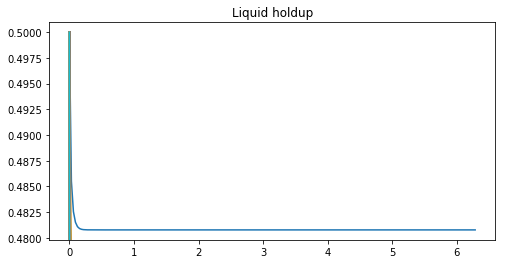

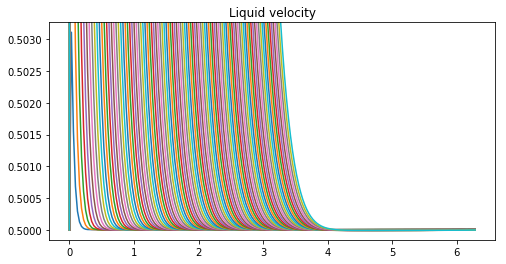

Time of the program's execution: 4.076957702636719e-05 seconds 


In [10]:
# Kreiss-Ystrom DG


# Kreiss-Ystrom equations: with higher order terms, with preconditioners and solvers parameters + functions
# Kreiss-Ystrom equations: with higher order terms, with preconditioners and solvers parameters
# Parameters
# https://fenicsproject.org/pub/tutorial/html/._ftut1017.html
"""
WAVE PDE SYSTEM
Solution of convection-diffusion equation using CG and backward Crank Nicholson
PDE: 
IC : 
BC : DIRICHLET

https://fenicsproject.discourse.group/t/aritymismatch-for-crank-nicolson-method-on-mixed-function-space/781/3
"""

from __future__ import print_function
from IPython.display import clear_output
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time


# Form compiler options
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
#parameters["form_compiler"]["representation"] = "quadrature"
parameters ["form_compiler"]["quadrature_degree"] = 2

parameters ["form_compiler"]["cpp_optimize"]      = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Allow approximating values for points that may be generated outside
# of domain (because of numerical inaccuracies)
parameters["allow_extrapolation"] = True
parameters["refinement_algorithm"] = "plaza_with_parent_facets"

# FIXME: Make mesh ghosted
parameters["ghost_mode"] = "shared_facet"

# Define constants
u1bc1   = 0.5 # alpha0
u2bc1   = 0.5 # u0 = 1.0
C       = - 1 # 1 non hyperbolic
nu      = 0.01 # 0 without viscosity (ill posed)
epsilon = 0.01

# Define space discretization properties
xmin   = 0
xmax   = 2*pi
nx     = 200 # no. of elements 100 to 800
p      = 2  # degree of FEM
mesh   = IntervalMesh (nx, xmin, xmax)
#deltax = CellDiameter (mesh)
deltax = 0.02 # 1 to 0.02m

# Define normal vector and mesh size
n     = FacetNormal(mesh)
h     = CellDiameter(mesh)
hmin  = mesh.hmin ()
h_avg = (h('+') + h('-'))/2

# Save mesh
File ("kreiss-ystrom_higherorder_prec_solvers/mesh.xml") << mesh

# Define time discretization properties
T         = 2.0            # final time
Co        = 0.5
dt        = Co*deltax/u2bc1 # 0.004*deltax
num_steps = round(T / dt)

# Define funcion spaces
V1      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
V2      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree=p)
element = MixedElement ([V1, V2])
V       = FunctionSpace (mesh, element)

# Define test and trial functions
v1, v2     = TestFunctions (V)

u          = Function (V, name = "Variables at current step")
u1, u2     = split (u)

du         = TrialFunction (V)

# Define initial condition
class InitialConditions (UserExpression):
    def __init__ (self, **kwargs):
        super (InitialConditions, self).__init__(**kwargs)
    def eval (self, values, x):
        values[0] = u1bc1
        values[1] = u2bc1
    def value_shape (self):
        return (2,)

u_ic       = InitialConditions(degree = p)
u_n        = interpolate (u_ic, V) 
u_n1, u_n2 = split (u_n)

# Define boundary condition
u1_bc1 = Expression ("u1bc1", degree = p, u1bc1 = u1bc1)
#u1_bc2 = Expression ("u1bc2", degree = p, u1bc2 = u1bc2)
u2_bc1 = Expression ("u2bc1", degree = p, u2bc1 = u2bc1)
#u2_bc2 = Expression ("u2bc2", degree = p, u2bc2 = u2bc2)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1 = DirichletBC(V.sub (0), u1_bc1, left)
#bc2 = DirichletBC(V.sub (1), u1_bc2, right)
bc3 = DirichletBC(V.sub (1), u2_bc1, left)
#bc4 = DirichletBC(V.sub (1), u2_bc2, right)
bcs = [bc1, bc3]

# Define expressions used in weak form
k       = Expression ("dt", degree = p, dt = dt)
nu      = Expression ("nu", degree = p, nu = nu)
epsilon = Expression ("epsilon", degree = p, epsilon = epsilon)
C       = Expression ("C", degree = p, C = C)

def func1(u1,u2):
    term1 = 1 + sin(u1/2)
    return term1

# Define variational form
n = FacetNormal(mesh)

# Define weak form
F = ((u1 - u_n1) / k)*v1*dx + (u2*v1*Dx(u1,0))*dx + ((func1 (u1, u2)))*(v1*Dx(u2,0))*dx + 2*u1*v1*dx + (inner(epsilon*grad(u1), grad(v1)))*dx +\
((u2 - u_n2) / k)*v2*dx + (u2*v2*Dx(u2,0))*dx - (C*v2*Dx(u1,0))*dx + (inner(nu*grad(u2), grad(v2)))*dx

#F = u1*v1*dx - 0.5*k*u2*v1*dx - (u_n1*v1*dx + 0.5*k*u_n2*v1*dx) +\
#u2*v2*dx + 0.5*c**2*k*inner(grad(u1), grad(v2))*dx - (u_n2*v2*dx - 0.5*c**2*k*inner(grad(u_n1), grad(v2))*dx)

# Define Jacobian
dF = derivative (F, u, du)

# Define files
ff1 = File ("kreiss-ystrom_higherorder_prec_solvers/u1.pvd", "compressed")
ff2 = File ("kreiss-ystrom_higherorder_prec_solvers/u2.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time
    t += dt
    #u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F, u, bcs = bcs, J = dF)
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters
    
    info(prm, True)
    
    prm ['nonlinear_solver'] = 'newton'
    prm ['print_matrix']     = False #True
    prm ['print_rhs']        = False #True
    prm ['symmetric']        = False #True
    
    prm ['newton_solver']['absolute_tolerance']      = 1E-8
    prm ['newton_solver']['convergence_criterion']   = 'incremental' #'residual'
    prm ['newton_solver']['error_on_nonconvergence'] = True
    prm ['newton_solver']['linear_solver']           = 'gmres'       #'ml_amg'
    prm ['newton_solver']['maximum_iterations']      = 25
    prm ['newton_solver']['preconditioner']          = 'ilu'
    prm ['newton_solver']['relative_tolerance']      = 1E-8
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['report']                  = True

    prm ['newton_solver']['krylov_solver']['absolute_tolerance']       = 1E-5 #1E-9
    #prm ['newton_solver']['krylov_solver']['divergence_limit']         = 
    prm ['newton_solver']['krylov_solver']['error_on_nonconvergence']  = True
    prm ['newton_solver']['krylov_solver']['maximum_iterations']       = 500000 # 500000
    prm ['newton_solver']['krylov_solver']["monitor_convergence"]      = True
    prm ['newton_solver']['krylov_solver']["nonzero_initial_guess"]    = True #False
    prm ['newton_solver']['krylov_solver']['relative_tolerance']       = 1E-3
    prm ['newton_solver']['krylov_solver']['report']                   = True
    
    prm ['newton_solver']['lu_solver']['report']    = True
    prm ['newton_solver']['lu_solver']['symmetric'] = True
    prm ['newton_solver']['lu_solver']['verbose']   = True

    PROGRESS = 16
    set_log_level(PROGRESS)
    
    solver.solve()

    (u1,u2) = u.split (deepcopy = True)
    
    # Plot solution
    plt.figure (1, figsize = (8, 4))
    #plt.clf()
    plot (u1, wireframe = True, title = "Liquid holdup") #plot alpha from 0.5 to 0.9
    
    plt.figure (2, figsize = (8, 4))
    #plt.clf()
    plot (u2, wireframe = True, title = "Liquid velocity")
             
    # Update previous solution
    u_n.assign (u)
    
    # Save solution
    ff1 << u1
    ff2 << u2

# Show all timings
list_timings(TimingClear.clear, [TimingType.wall])

# Hold plot
plt.show ()

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))
    
    
    ####como subir o grau do polinomio???

In [6]:
# Auto Adaptive N_S
#https://bitbucket.org/fenics-project/dolfin/src/cca9a4d76bbd15801aaf965ac110d13d1fafa3c2/python/demo/undocumented/auto-adaptive-navier-stokes/demo_auto-adaptive-navier-stokes.py
    

Iteration : 100.00000000000007 of 100
Time      : 2.0000000000000013 s


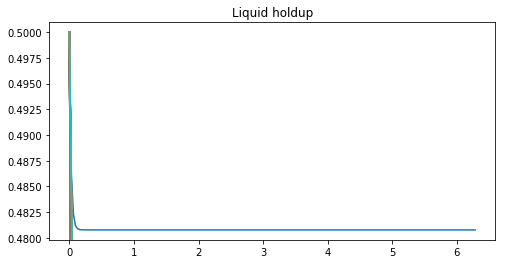

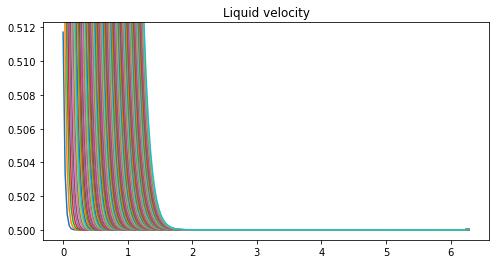

Time of the program's execution: 4.100799560546875e-05 seconds 


In [2]:
#CG, p=1
#DG, p=0

# Kreiss-Ystrom equations: with higher order terms, with preconditioners and solvers parameters + functions
# Kreiss-Ystrom equations: with higher order terms, with preconditioners and solvers parameters
# Parameters
# https://fenicsproject.org/pub/tutorial/html/._ftut1017.html
"""
WAVE PDE SYSTEM
Solution of convection-diffusion equation using CG and backward Crank Nicholson
PDE: 
IC : 
BC : DIRICHLET

https://fenicsproject.discourse.group/t/aritymismatch-for-crank-nicolson-method-on-mixed-function-space/781/3
"""

from __future__ import print_function
from IPython.display import clear_output
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import time


# Form compiler options
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
#parameters["form_compiler"]["representation"] = "quadrature"
parameters ["form_compiler"]["quadrature_degree"] = 2

parameters ["form_compiler"]["cpp_optimize"]      = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Allow approximating values for points that may be generated outside
# of domain (because of numerical inaccuracies)
parameters["allow_extrapolation"] = True
parameters["refinement_algorithm"] = "plaza_with_parent_facets"

# FIXME: Make mesh ghosted
parameters["ghost_mode"] = "shared_facet"

# Define constants
u1bc1   = 0.5 # alpha0
u2bc1   = 0.5 # u0 = 1.0
C       = - 1 # 1 non hyperbolic
nu      = 0.01 # 0 without viscosity (ill posed)
epsilon = 0.01

# Define space discretization properties
xmin   = 0
xmax   = 2*pi
nx     = 200 # no. of elements 100 to 800
p      = 2  # degree of FEM
mesh   = IntervalMesh (nx, xmin, xmax)
#deltax = CellDiameter (mesh)
deltax = 0.02 # 1 to 0.02m

# Define normal vector and mesh size
n     = FacetNormal(mesh)
h     = CellDiameter(mesh)
hmin  = mesh.hmin ()
h_avg = (h('+') + h('-'))/2

# Save mesh
File ("kreiss-ystrom_higherorder_prec_solvers/mesh.xml") << mesh

# Define time discretization properties
T         = 2.0            # final time
Co        = 0.5
dt        = Co*deltax/u2bc1 # 0.004*deltax
num_steps = round(T / dt)

# Define funcion spaces
V1      = FiniteElement ('Lagrange', mesh.ufl_cell(), degree = p)
V2      = FiniteElement ('DG', mesh.ufl_cell(), degree = p-1)
element = MixedElement ([V1, V2])
V       = FunctionSpace (mesh, element)

# Define test and trial functions
v1, v2     = TestFunctions (V)

u          = Function (V, name = "Variables at current step")
u1, u2     = split (u)

du         = TrialFunction (V)

# Define initial condition
class InitialConditions (UserExpression):
    def __init__ (self, **kwargs):
        super (InitialConditions, self).__init__(**kwargs)
    def eval (self, values, x):
        values[0] = u1bc1
        values[1] = u2bc1
    def value_shape (self):
        return (2,)

u_ic       = InitialConditions(degree = p)
u_n        = interpolate (u_ic, V) 
u_n1, u_n2 = split (u_n)

# Define boundary condition
u1_bc1 = Expression ("u1bc1", degree = p, u1bc1 = u1bc1)
#u1_bc2 = Expression ("u1bc2", degree = p, u1bc2 = u1bc2)
u2_bc1 = Expression ("u2bc1", degree = p, u2bc1 = u2bc1)
#u2_bc2 = Expression ("u2bc2", degree = p, u2bc2 = u2bc2)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1 = DirichletBC(V.sub (0), u1_bc1, left)
#bc2 = DirichletBC(V.sub (1), u1_bc2, right)
bc3 = DirichletBC(V.sub (1), u2_bc1, left)
#bc4 = DirichletBC(V.sub (1), u2_bc2, right)
bcs = [bc1, bc3]

# Define expressions used in weak form
k       = Expression ("dt", degree = p, dt = dt)
nu      = Expression ("nu", degree = p, nu = nu)
epsilon = Expression ("epsilon", degree = p, epsilon = epsilon)
C       = Expression ("C", degree = p, C = C)

def func1(u1,u2):
    term1 = 1 + sin(u1/2)
    return term1

# Define variational form
n = FacetNormal(mesh)

# Define weak form
F = ((u1 - u_n1) / k)*v1*dx + (u2*v1*Dx(u1,0))*dx + ((func1 (u1, u2)))*(v1*Dx(u2,0))*dx + 2*u1*v1*dx + (inner(epsilon*grad(u1), grad(v1)))*dx +\
((u2 - u_n2) / k)*v2*dx + (u2*v2*Dx(u2,0))*dx - (C*v2*Dx(u1,0))*dx + (inner(nu*grad(u2), grad(v2)))*dx

#F = u1*v1*dx - 0.5*k*u2*v1*dx - (u_n1*v1*dx + 0.5*k*u_n2*v1*dx) +\
#u2*v2*dx + 0.5*c**2*k*inner(grad(u1), grad(v2))*dx - (u_n2*v2*dx - 0.5*c**2*k*inner(grad(u_n1), grad(v2))*dx)

# Define Jacobian
dF = derivative (F, u, du)

# Define files
ff1 = File ("kreiss-ystrom_higherorder_prec_solvers/u1.pvd", "compressed")
ff2 = File ("kreiss-ystrom_higherorder_prec_solvers/u2.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time
    t += dt
    #u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F, u, bcs = bcs, J = dF)
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters
    
    info(prm, True)
    
    prm ['nonlinear_solver'] = 'newton'
    prm ['print_matrix']     = False #True
    prm ['print_rhs']        = False #True
    prm ['symmetric']        = False #True
    
    prm ['newton_solver']['absolute_tolerance']      = 1E-8
    prm ['newton_solver']['convergence_criterion']   = 'incremental' #'residual'
    prm ['newton_solver']['error_on_nonconvergence'] = True
    prm ['newton_solver']['linear_solver']           = 'gmres'       #'ml_amg'
    prm ['newton_solver']['maximum_iterations']      = 25
    prm ['newton_solver']['preconditioner']          = 'sor'
    prm ['newton_solver']['relative_tolerance']      = 1E-8
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['report']                  = True

    prm ['newton_solver']['krylov_solver']['absolute_tolerance']       = 1E-5 #1E-9
    #prm ['newton_solver']['krylov_solver']['divergence_limit']         = 
    prm ['newton_solver']['krylov_solver']['error_on_nonconvergence']  = True
    prm ['newton_solver']['krylov_solver']['maximum_iterations']       = 500000 # 500000
    prm ['newton_solver']['krylov_solver']["monitor_convergence"]      = True
    prm ['newton_solver']['krylov_solver']["nonzero_initial_guess"]    = True #False
    prm ['newton_solver']['krylov_solver']['relative_tolerance']       = 1E-3
    prm ['newton_solver']['krylov_solver']['report']                   = True
    
    prm ['newton_solver']['lu_solver']['report']    = True
    prm ['newton_solver']['lu_solver']['symmetric'] = True
    prm ['newton_solver']['lu_solver']['verbose']   = True

    PROGRESS = 16
    set_log_level(PROGRESS)
    
    solver.solve()

    (u1,u2) = u.split (deepcopy = True)
    
    # Plot solution
    plt.figure (1, figsize = (8, 4))
    #plt.clf()
    plot (u1, wireframe = True, title = "Liquid holdup") #plot alpha from 0.5 to 0.9
    
    plt.figure (2, figsize = (8, 4))
    #plt.clf()
    plot (u2, wireframe = True, title = "Liquid velocity")
             
    # Update previous solution
    u_n.assign (u)
    
    # Save solution
    ff1 << u1
    ff2 << u2

# Show all timings
list_timings(TimingClear.clear, [TimingType.wall])

# Hold plot
plt.show ()

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))
    
    
    ####como subir o grau do polinomio???